### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 9

### Experiments data

In [5]:
components_dictionary = {'experiment_2': ['Pinene', 'Benzyl benzoate'],
                        'experiment_3': ['Pinene', 'Limonene'],
                        'experiment_4': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_5': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_8': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_6': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_7': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Benzyl benzoate', 'm Anisaldehyde']}

In [6]:
protons_dictionary = {'experiment_2': [16, 12],
                        'experiment_3': [16, 16],
                        'experiment_4': [12, 8],
                        'experiment_5': [34, 12, 16, 16],
                        'experiment_1': [16, 12],
                        'experiment_8': [4, 4, 5, 5, 13],
                        'experiment_6': [4, 4, 5, 5, 13],
                        'experiment_7': [4, 4, 5, 5, 13],
                        'experiment_9': [12, 8]}

In [7]:
ground_truth_molar_proportions = {'experiment_2': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_3': [0.505, 0.495],
                                    'experiment_4': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_5': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_1': [0.3865, 0.6135],
                                    'experiment_8': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_6': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_7': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3702, 0.6298]}

In [8]:
experiments_folders = {'experiment_2': 'experiment_2_intensity_difference',
                        'experiment_1': 'experiment_1_miniperfumes',
                        'experiment_8': 'experiment_8_metabolites',
                         'experiment_4': 'experiment_4_overlapping_and_intensity_difference',
                         'experiment_6': 'experiment_6_and_7_shim',
                       'experiment_7': 'experiment_6_and_7_shim',
                        'experiment_9': 'experiment_9_different_solvents',
                        'experiment_5': 'experiment_5_perfumes_and_absent_components',
                         'experiment_3': 'experiment_3_overlapping'}

In [9]:
#best_kappa_mix = [0.09, 0.05, 0.23, 0.37, 0.06, 0.03, 0.05, 0.11, 0.2]
best_kappa_mix = [0.06, 0.09, 0.05, 0.23, 0.37, 0.05, 0.11, 0.03, 0.2]

In [10]:
#best_kappa_model = [0.08, 0.01, 0.02, 0.24, 0.2, 0.09, 0.02, 0.02, 0.29]
best_kappa_model = [0.2, 0.08, 0.01, 0.02, 0.24, 0.02, 0.02, 0.09, 0.29]

### Loading the data

In [11]:
if (nr_of_experiment != 6 and nr_of_experiment != 7):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [12]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [13]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 6 and nr_of_experiment != 7):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [14]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [15]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [16]:
# mix.plot(profile=True)
# for sp in spectra:
#     sp.plot(profile=True)

### Estimation

In [17]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Initial filtering of formulas: 100%|████████████| 2/2 [00:00<00:00, 58.24it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|██████████████████████| 2/2 [00:00<00:00, 79891.50it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.2100299999999997, 12.28995)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 3449093.11it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                              | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|█████████████████████| 1/1 [03:12<00:00, 192.63s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9298597180920001
Noise proportion in experimental spectrum: 0.07014029297699982
Total explanation: 1.000000011069
Noise proportion in combination of theoretical spectra: 0.008558474193


In [18]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 192.77701354026794 seconds.


In [19]:
estimation_vis['proportions']

[0.43970247519399885, 0.49015724289799867]

In [20]:
estimation_vis['proportion_of_noise_in_theoretical']

0.008558474192999977

In [21]:
start_con = time.time()
estimation_molar = estimate_proportions(mix, spectra,
                                        MTD=best_kappa_mix[nr_of_experiment-1], 
                                        MTD_th=best_kappa_model[nr_of_experiment-1],
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con = time.time()

Initial filtering of formulas: 100%|████████████| 2/2 [00:00<00:00, 56.17it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|██████████████████████| 2/2 [00:00<00:00, 66576.25it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.2100299999999997, 12.28995)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 3421776.79it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                              | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


Deconvolving chunks: 100%|█████████████████████| 1/1 [03:13<00:00, 193.37s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9298597180920001
Noise proportion in experimental spectrum: 0.07014029297699982
Total explanation: 1.000000011069
Noise proportion in combination of theoretical spectra: 0.008558474193


In [22]:
print('Estimation took '+ str(stop_con-start_con) + ' seconds.')

Estimation took 193.52244234085083 seconds.


In [23]:
estimation_molar['proportions']

[0.37423451120488055, 0.6257654887951195]

### Saving estimation results

In [24]:
res_vis = pd.DataFrame(np.array(estimation_vis['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis

,Benzyl benzoate,m Anisaldehyde
0,0.439702,0.490157


In [25]:
res_con = pd.DataFrame(np.array(estimation_molar['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con

,Benzyl benzoate,m Anisaldehyde
0,0.374235,0.625765


In [26]:
# if (nr_of_experiment != 6 and nr_of_experiment != 7):
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area.csv')
# else:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_exp'+str(nr_of_experiment)+'.csv')

In [27]:
# if (nr_of_experiment != 6 and nr_of_experiment != 7):
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration.csv')
# else:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_exp'+str(nr_of_experiment)+'.csv')

### Mixture vs linear combination of components (noise removed)

In [26]:
ignore_negative = False

In [27]:
def make_nonnegative(ints):
    res_ints = ints
    for col_nr in range(ints.shape[1]):
        neg = ints[:,col_nr]<0
        res_ints[:,col_nr][neg]=0
    return(res_ints)

#### Mix

In [28]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [29]:
mix_without_noise = NMRSpectrum(confs = list(zip(ppm, mix_ints - np.array(estimation_vis['noise']))))
mix_without_noise = np.array(mix_without_noise.confs)[:,1]

In [30]:
if ignore_negative:
    mix_without_noise = make_nonnegative(mix_without_noise.reshape(-1,1))

In [31]:
mix_without_noise = mix_without_noise/sum(mix_without_noise)

#### Components

In [32]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [35]:
p = estimation_vis['proportions']
p = np.array(p).reshape(len(p),1)

In [36]:
names_components_up_to = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [37]:
components = [comp.reshape(-1,1) for comp in components_ints]
components_no_scaling = np.concatenate(components, axis=1)
components_scaled = components_no_scaling*p[:,0]

In [38]:
proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))
proportions_point_by_point = np.nan_to_num(proportions_point_by_point)
noise_in_ref = np.array(estimation_vis['noise_in_theoretical']).reshape(-1,1)
noise_split_for_components = proportions_point_by_point*noise_in_ref

/tmp/ipykernel_87069/2062537961.py:1: RuntimeWarning: invalid value encountered in divide
  proportions_point_by_point = (components_scaled/np.sum(components_scaled, axis=1).reshape(-1,1))


In [39]:
(np.round(components_scaled-noise_split_for_components, decimals=5)>=0).all()

True

In [40]:
X = components_scaled - noise_split_for_components

In [41]:
(np.sum(X[:,:1], axis=1)==X[:,0]).all()

True

In [42]:
if ignore_negative:
    X = make_nonnegative(X)

In [43]:
for i, name in enumerate(names_components_up_to):
    #not_normalized = np.sum(X[:,:(i+1)], axis=1)
    
    globals()[name] = np.sum(X[:,:(i+1)], axis=1)

In [44]:
xlims_lower = [1.55, 1.55, 1.6, 7.3, 4.4, 3.55, 3.55, 3.55, 9.1]
xlims_upper = [2.4, 2.45, 2.4, 7.6, 7.8, 4.05, 4.05, 4.05, 10.1]
ylims_lower = [-0.00005, -0.00005, -0.00005, -0.00005, -0.000025, -0.00005, -0.00005, -0.00005, -0.00005]
ylims_upper = [0.0016, 0.00045, 0.0025, 0.0026, 0.00016, 0.0016, 0.0016, 0.0011, 0.0014]

<IPython.core.display.Javascript object>


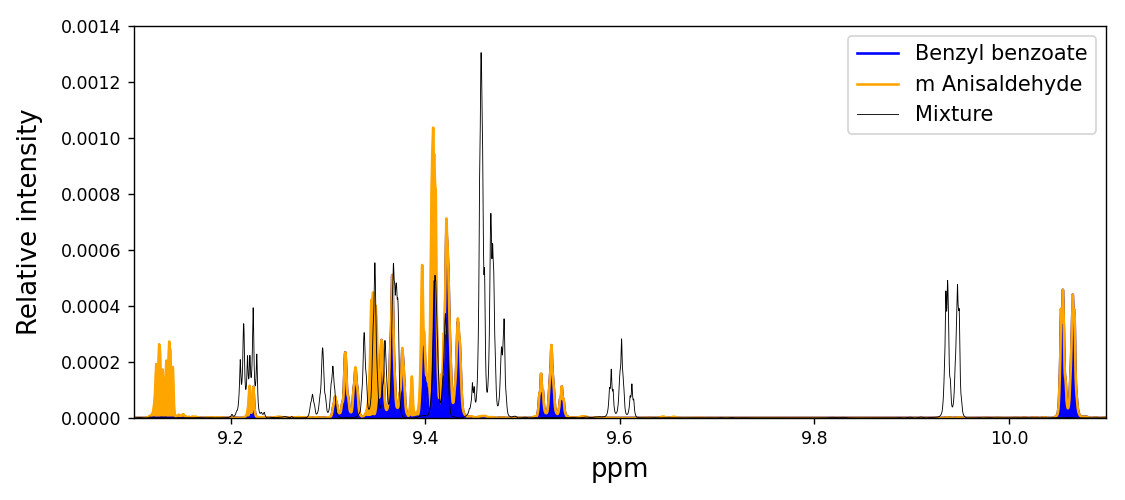

In [45]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)

ax.set_xlim(xlims_lower[nr_of_experiment-1], xlims_upper[nr_of_experiment-1])
ax.set_ylim(None, ylims_upper[nr_of_experiment-1])


plt.xlabel('ppm', fontsize=15, labelpad=5)
plt.ylabel('Relative intensity', fontsize=15, labelpad=10)

for i, name in enumerate(names_components_up_to):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], 
            label=components_dictionary['experiment_'+str(nr_of_experiment)][i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_without_noise, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12}, loc='upper right')
plt.tight_layout()
plt.savefig(os.getcwd()+'/spectra_visualisation/experiment'+str(nr_of_experiment)+'.jpg', dpi=300)

In [46]:
estimation_vis['proportion_of_noise_in_theoretical']

0.008558474192999977

In [47]:
1-sum(estimation_vis['proportions'])

0.07014028190800248

In [48]:
estimation_vis['proportions']

[0.43970247519399885, 0.49015724289799867]